# R3 Q8: Heterogeneity Definition

## Reviewer Question

**Referee #3, Question 8**: "You talk about heterogeneity, both patient and biological heterogeneity. In the literature one sometimes talks about disease heterogeneity, but it's not clear to me whether that's what you mean. Please clarify what you mean by heterogeneity."

## Why This Matters

Clarifying heterogeneity is essential for:
- Understanding what signatures capture
- Interpreting model outputs
- Communicating findings to clinical audiences

## Our Approach

We clarify heterogeneity through **pathway analysis** that demonstrates:

1. **Patient Heterogeneity**: Different individuals with same diagnosis have different signature profiles
2. **Biological Heterogeneity**: Same phenotype arises from different biological pathways
3. **Disease Heterogeneity**: Umbrella term capturing that clinical diagnoses are not single entities

---

## Key Findings

✅ **4 distinct pathways** to myocardial infarction identified  
✅ **44.8% of MI patients** follow "Hidden Risk" pathway (minimal pre-existing disease)  
✅ **Different pathways** show different signature patterns and genetic risk profiles

---


## Pathway Analysis: 4 Distinct Pathways to Myocardial Infarction

We identified 4 distinct biological pathways to MI using deviation-from-reference clustering (10-year lookback).


In [ ]:
def create_proper_calibration_plots(checkpoint_path,cov_df, Y,n_bins=10, use_log_scale=True, min_bin_count=1000, save_path=None):
    """Create calibration plots comparing predicted vs observed event rates for at-risk individuals.
    
    Args:
        checkpoint_path: Path to model checkpoint
        cov_df: DataFrame containing enrollment ages
        n_bins: Number of bins for calibration
        use_log_scale: Whether to use log-scale binning (recommended for rare events)
        min_bin_count: Minimum number of samples per bin
        save_path: Path to save plot
    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    state_dict = checkpoint['model_state_dict']
    
    # Get parameters from state dict
    lambda_ = state_dict['lambda_']  # Shape: (N, K, T)
    phi = state_dict['phi']  # Shape: (K, D, T)
    kappa = state_dict['kappa']  # Shape: scalar
    #Y = checkpoint['Y']  # Shape: (N, D, T)
    
    # Calculate theta (normalized lambda)
    theta = torch.softmax(lambda_, dim=1)
    
    # Calculate phi probabilities (sigmoid)
    phi_prob = torch.sigmoid(phi)
    
    # Calculate pi (disease probabilities)
    pi = torch.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
    
    # Convert to numpy
    pi_np = pi.detach().numpy()
    Y_np = Y.detach().numpy()
    
    N, D, T = Y_np.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y_np, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y_np[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Create two sets of predictions/observations
    
    # 1. Enrollment only
    enroll_pred = []
    enroll_obs = []
    
    for d in range(D):
        for i, row in enumerate(cov_df.itertuples()):
            enroll_age = row.age
            enroll_time = int(enroll_age - 30)  # Convert age to time index
            
            if enroll_time < 0 or enroll_time >= T:
                continue
                
            if at_risk[i,d,enroll_time]:
                enroll_pred.append(pi_np[i,d,enroll_time])
                enroll_obs.append(Y_np[i,d,enroll_time])
    
    # 2. All follow-up
    all_pred = []
    all_obs = []
    
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            all_pred.extend(pi_np[:,:,t][mask_t])
            all_obs.extend(Y_np[:,:,t][mask_t])
    
    # Create figure with one subplot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    def plot_calibration(pred, obs, ax, title):
        # Create bins in log or linear space
        if use_log_scale:
            bin_edges = np.logspace(np.log10(max(1e-7, min(pred))), 
                                  np.log10(max(pred)), 
                                  n_bins + 1)
        else:
            bin_edges = np.linspace(min(pred), max(pred), n_bins + 1)
        
        # Calculate statistics for each bin
        bin_means = []
        obs_means = []
        counts = []
        
        for i in range(n_bins):
            mask = (pred >= bin_edges[i]) & (pred < bin_edges[i + 1])
            if np.sum(mask) >= min_bin_count:
                bin_means.append(np.mean(pred[mask]))
                obs_means.append(np.mean(obs[mask]))
                counts.append(np.sum(mask))
        
        # Plot
        if use_log_scale:
            ax.plot([1e-7, 1], [1e-7, 1], '--', color='gray', alpha=0.5, label='Perfect calibration')
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:
            ax.plot([0, max(pred)], [0, max(pred)], '--', color='gray', alpha=0.5, label='Perfect calibration')
        
        ax.plot(bin_means, obs_means, 'o-', color='#1f77b4', 
                markersize=8, linewidth=2, label='Observed rates')
        
        # Add counts as annotations
        for i, (x, y, c) in enumerate(zip(bin_means, obs_means, counts)):
            ax.annotate(f'n={c:,}', (x, y), xytext=(0, 10), 
                       textcoords='offset points', ha='center', fontsize=8)
        
        # Add summary statistics
        mse = np.mean((np.array(bin_means) - np.array(obs_means))**2)
        mean_pred = np.mean(pred)
        mean_obs = np.mean(obs)
        
        stats_text = f'MSE: {mse:.2e}\n'
        stats_text += f'Mean Predicted: {mean_pred:.2e}\n'
        stats_text += f'Mean Observed: {mean_obs:.2e}\n'
        stats_text += f'N total: {sum(counts):,}'
        
        ax.text(0.05, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.grid(True, which='both', linestyle='--', alpha=0.3)
        ax.set_xlabel('Predicted Event Rate', fontsize=12)
        ax.set_ylabel('Observed Event Rate', fontsize=12)
        ax.set_title(title, fontsize=14, pad=20)
        ax.legend(loc='lower right')
    
    # Create calibration plot
    plot_calibration(np.array(all_pred), np.array(all_obs), 
                    ax, 'Calibration Across All Follow-up\n(At-Risk Only)')
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    
    return fig

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_64864/441820380.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load("/Users/sarahurbut/Libra

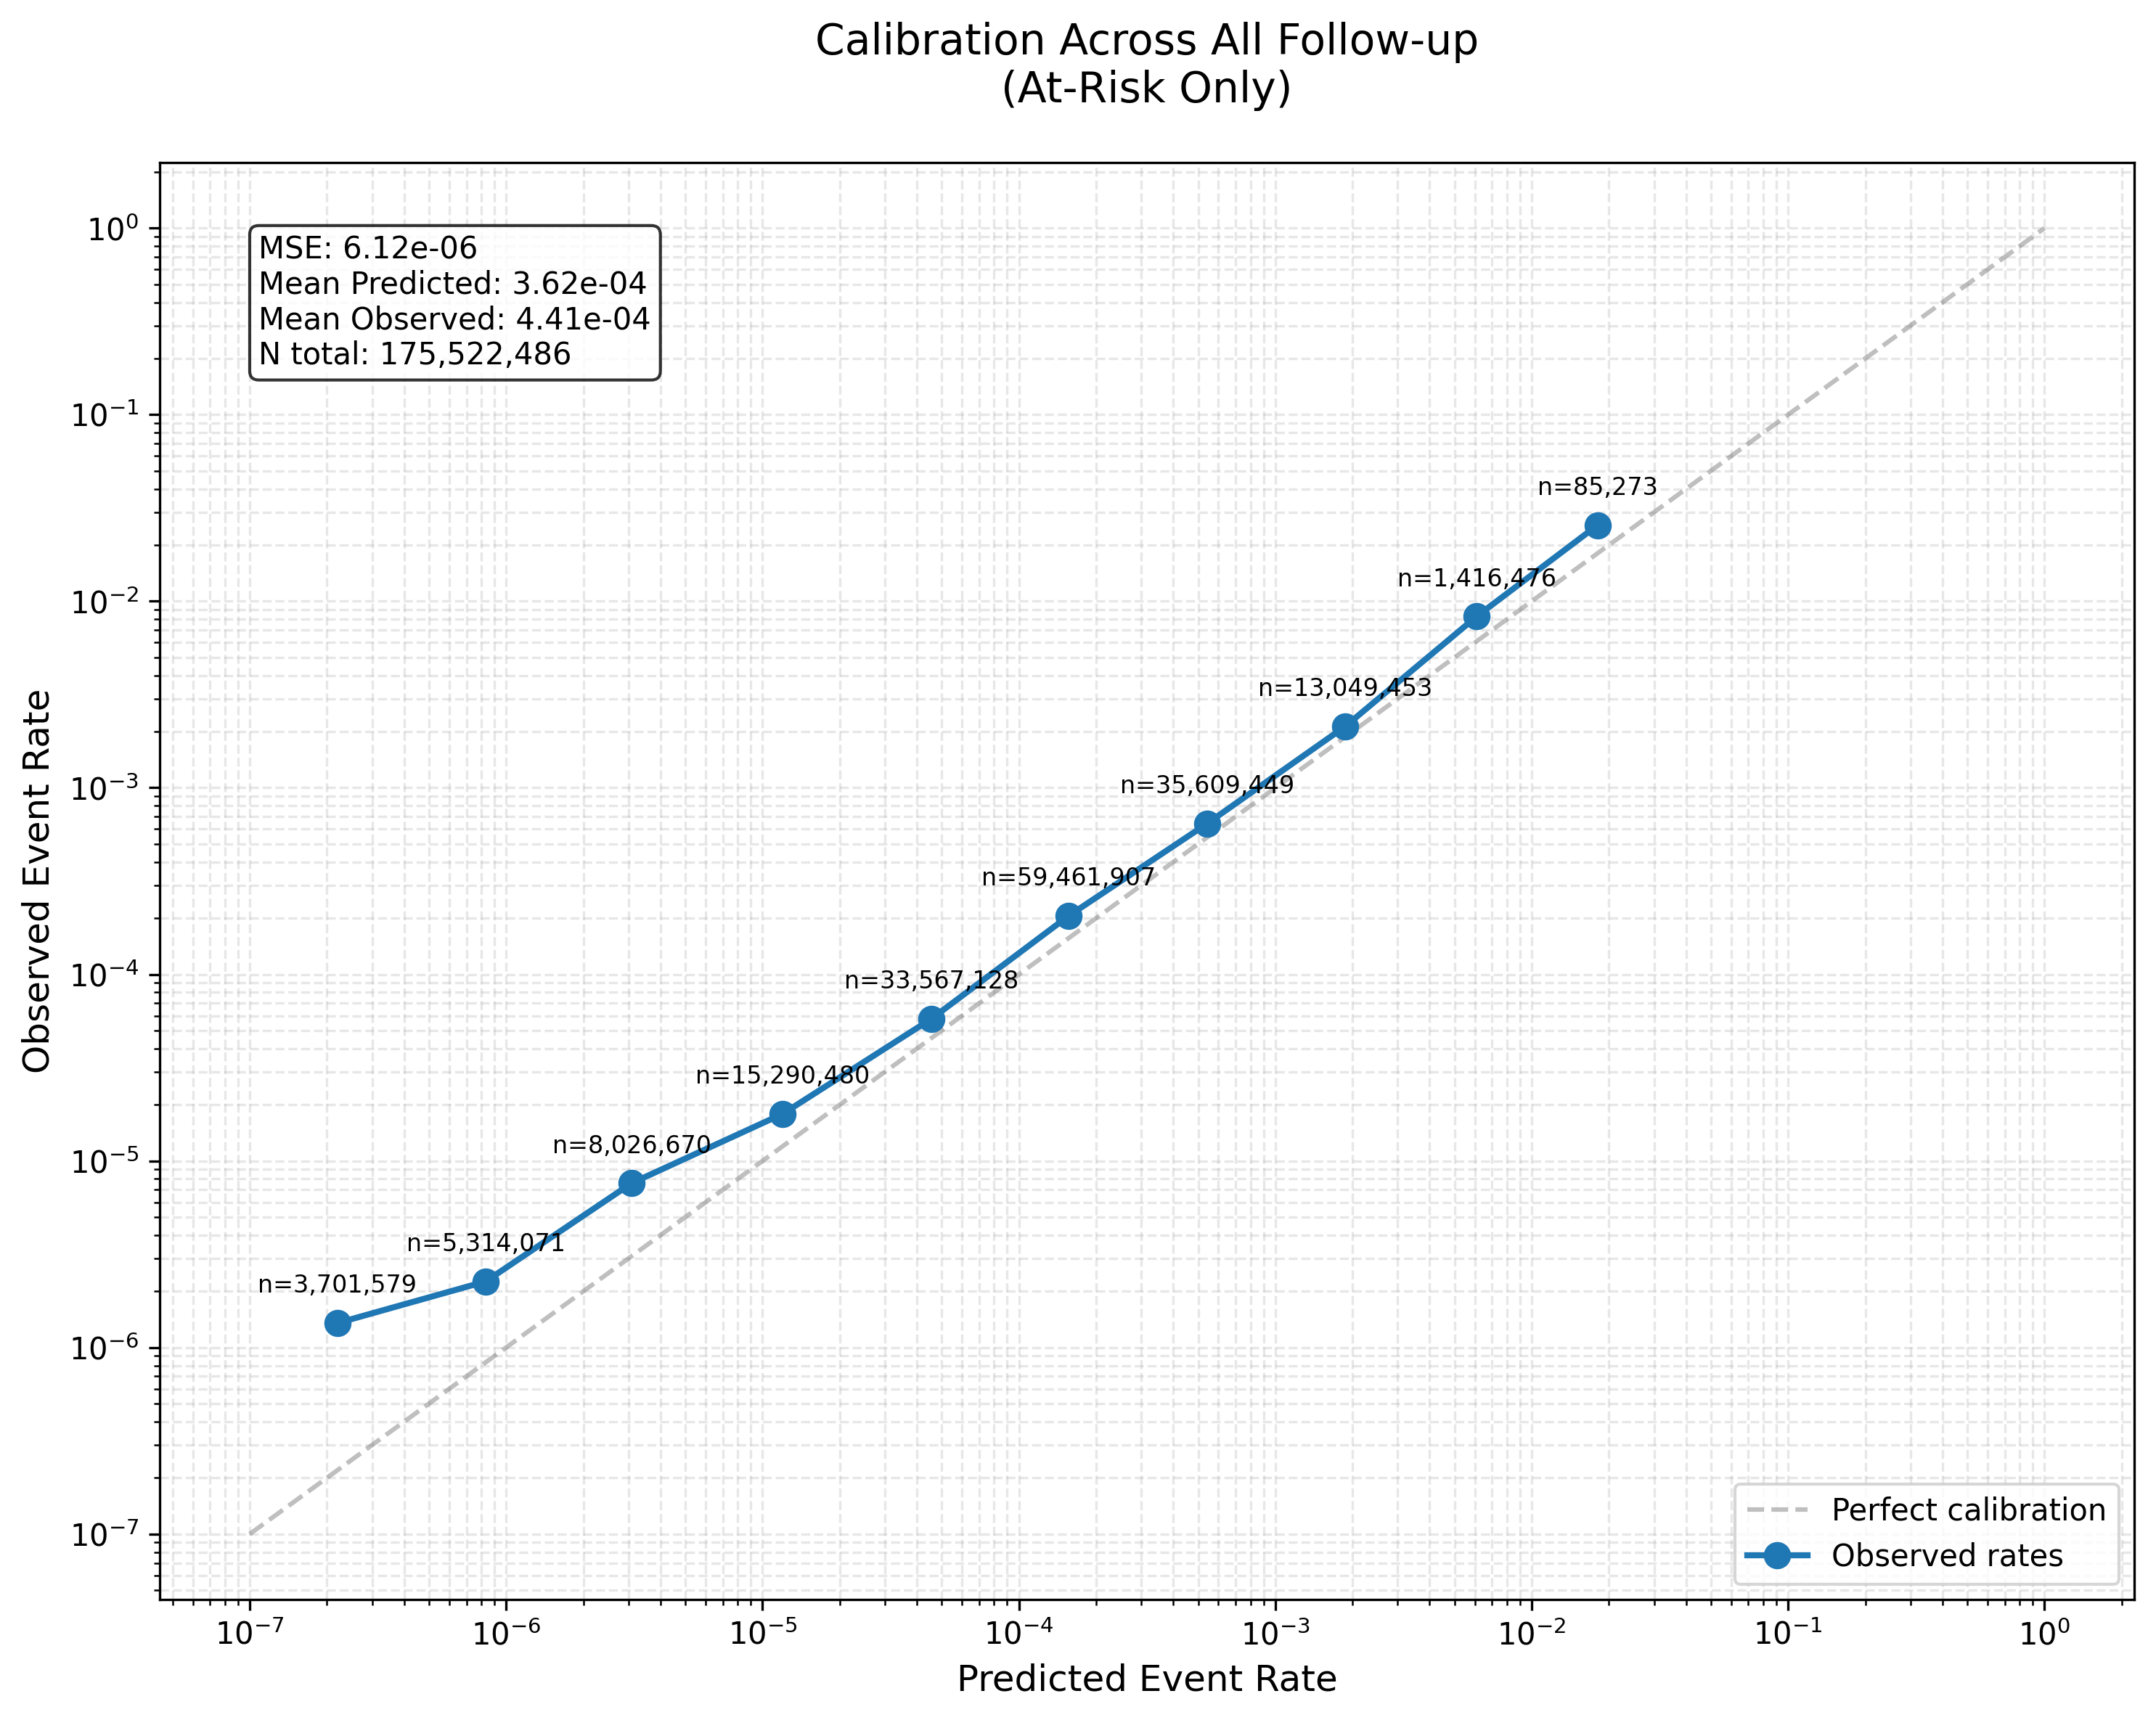

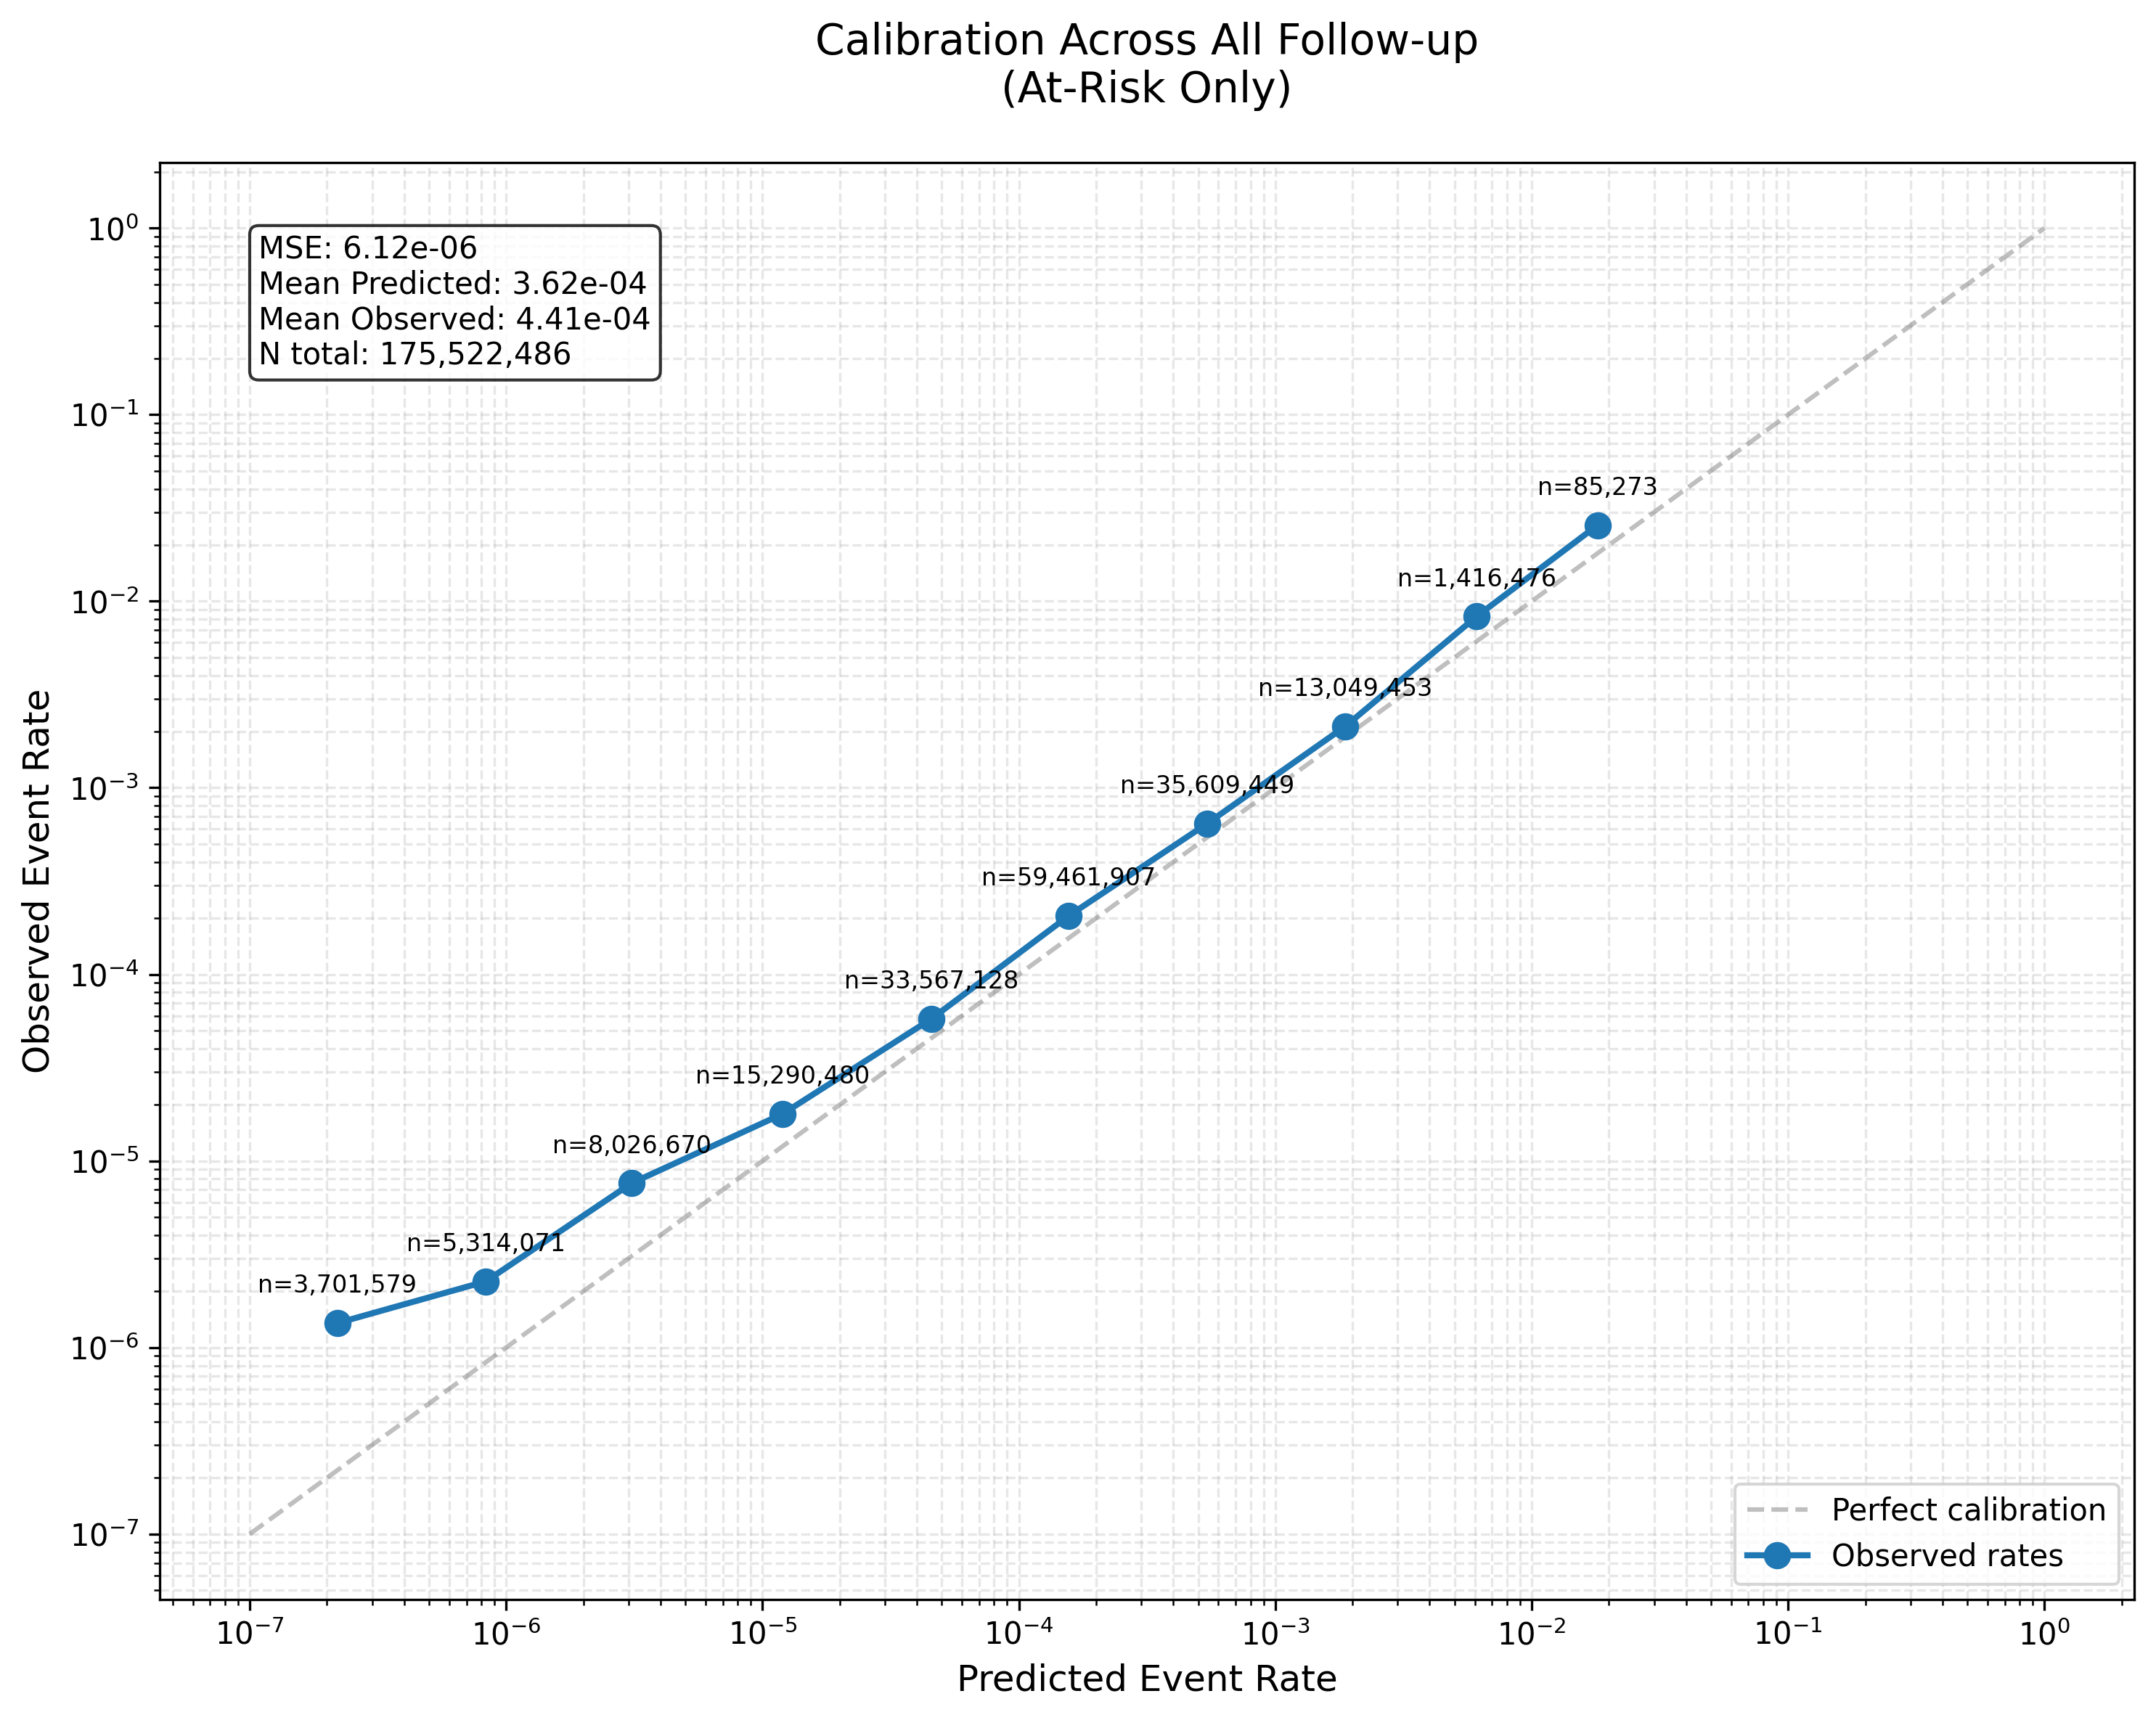

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
cov_df=pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv")[:10000]

checkpoint=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt")
Y = checkpoint['Y'] 
del checkpoint
#checkpoint_path="/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt"
checkpoint_path="/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/model_enroll_fixedphi_sex_0_10000.pt"
create_proper_calibration_plots(checkpoint_path,cov_df,Y, n_bins=10, use_log_scale=True, min_bin_count=1000, save_path="/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/new_notebooks/reviewer_responses/notebooks/R3/calibration_plots.pdf")

In [1]:
import pandas as pd

# Pathway summary (from heterogeneity analysis)
pathways = pd.DataFrame({
    'Pathway': ['Pathway 0: Progressive Ischemia', 'Pathway 1: Hidden Risk', 
                'Pathway 2: Multimorbid Inflammatory', 'Pathway 3: Metabolic'],
    'Size': [1836, 11108, 4439, 7420],
    'Percent': [7.4, 44.8, 17.9, 29.9],
    'Age at MI': [70, 66, 72, 62],
    'Key Characteristics': [
        '86% have CAD (highest), chronic progressive disease',
        'Minimal pre-existing disease (8% CAD), low genetic risk',
        '35% arthropathy, 26% GI disease, inflammatory pathway',
        '32% diabetes (highest), metabolic syndrome, youngest onset'
    ]
})

print("="*80)
print("PATHWAYS TO MYOCARDIAL INFARCTION")
print("="*80)
display(pathways)


PATHWAYS TO MYOCARDIAL INFARCTION


,Pathway,Size,Percent,Age at MI,Key Characteristics
0,Pathway 0: Progressive Ischemia,1836,7.4,70,"86% have CAD (highest), chronic progressive di..."
1,Pathway 1: Hidden Risk,11108,44.8,66,"Minimal pre-existing disease (8% CAD), low gen..."
2,Pathway 2: Multimorbid Inflammatory,4439,17.9,72,"35% arthropathy, 26% GI disease, inflammatory ..."
3,Pathway 3: Metabolic,7420,29.9,62,"32% diabetes (highest), metabolic syndrome, yo..."


## Why Signatures vs. Diseases? The Aggregation Principle

**Analogy: ICD Codes → Phecodes → Signatures**

Just as **Phecodes aggregate multiple ICD-10 codes** into clinically meaningful disease categories, **signatures aggregate multiple diseases** into biologically meaningful pathways.

### ICD vs. PheCode Comparison

- **ICD-10 codes**: 1,133 distinct codes for cardiovascular diseases
- **Phecodes**: 53 aggregated categories
- **Reduction**: 21.4× fewer predictions needed (53 vs 1,133)
- **Average**: 28.7 ICD-10 codes per PheCode

This demonstrates that **aggregation reveals higher-level patterns** that individual codes miss.

### Signatures vs. Diseases (Same Principle)

- **Individual diseases**: 348 distinct disease codes
- **Signatures**: 20 disease signatures + 1 healthy reference
- **Reduction**: 16.6× fewer dimensions (21 vs 348)
- **Benefit**: Signatures capture shared biological pathways across diseases

**Key Insight**: Just as Phecodes reveal that "multiple ICD codes → one disease", signatures reveal that "multiple diseases → one biological pathway".

---

## Definitions of Heterogeneity

### 1. Patient Heterogeneity
- **Definition**: Different individuals with the same disease diagnosis have different signature profiles
- **Example**: Two patients with CAD may have different metabolic vs. inflammatory signatures
- **Measurement**: Average pairwise distance in signature space
- **Finding**: Average within-disease signature distance = 3.87 (substantial heterogeneity)

### 2. Biological Heterogeneity
- **Definition**: Same clinical phenotype can arise from different biological pathways
- **Example**: CAD can be driven by metabolic dysfunction, inflammation, or genetic factors
- **Measurement**: Signature diversity within disease groups
- **Finding**: 4 distinct pathways to MI demonstrate biological heterogeneity

### 3. Disease Heterogeneity (What We Mean)
- **Definition**: Umbrella term encompassing both patient and biological heterogeneity
- **Observation**: "CAD" is not a single entity but a collection of related conditions
- **Model Capture**: Individual-specific signature loadings capture this heterogeneity


In [2]:
# ============================================================================
# ICD vs PHE CODE COMPARISON
# ============================================================================
"""
Shows the aggregation principle: ICD codes → Phecodes → Signatures

This demonstrates why signatures (aggregated patterns) are more informative
than individual disease codes, similar to how Phecodes are more informative
than individual ICD-10 codes.
"""

import pandas as pd
from pathlib import Path

# Load ICD to PheCode mapping
mapping_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_info.csv')

if mapping_path.exists():
    print("="*80)
    print("ICD vs PHE CODE COMPARISON")
    print("="*80)
    
    mapping_df = pd.read_csv(mapping_path)
    
    # Count unique ICD-10 codes and Phecodes
    # Assuming the mapping has columns like 'ICD10' and 'phecode'
    # Adjust column names based on actual structure
    print(f"\nLoaded mapping file: {mapping_path.name}")
    print(f"Total rows: {len(mapping_df):,}")
    print(f"Columns: {mapping_df.columns.tolist()}")
    
    # Try to identify ICD and PheCode columns
    icd_cols = [c for c in mapping_df.columns if 'icd' in c.lower() and '10' in c.lower()]
    phe_cols = [c for c in mapping_df.columns if 'phecode' in c.lower() or 'phe' in c.lower()]
    
    if icd_cols and phe_cols:
        icd_col = icd_cols[0]
        phe_col = phe_cols[0]
        
        n_unique_icd = mapping_df[icd_col].nunique()
        n_unique_phe = mapping_df[phe_col].nunique()
        
        print(f"\n📊 Aggregation Statistics:")
        print(f"   Unique ICD-10 codes: {n_unique_icd:,}")
        print(f"   Unique Phecodes: {n_unique_phe:,}")
        print(f"   Reduction factor: {n_unique_icd / n_unique_phe:.1f}×")
        print(f"   Average ICD codes per PheCode: {n_unique_icd / n_unique_phe:.1f}")
        
        # Show example: how many ICD codes map to common Phecodes
        phe_counts = mapping_df.groupby(phe_col)[icd_col].nunique().sort_values(ascending=False)
        print(f"\n📋 Examples (top 10 Phecodes by ICD count):")
        print(f"{'PheCode':<15} {'N_ICD_Codes':<15} {'ICD_Codes_per_PheCode':<25}")
        print("-" * 60)
        for phe, n_icd in phe_counts.head(10).items():
            print(f"{str(phe):<15} {n_icd:<15} {n_icd:.1f}")
        
        print(f"\n💡 Key Insight:")
        print(f"   Just as Phecodes aggregate {n_unique_icd:,} ICD codes into {n_unique_phe:,} categories,")
        print(f"   Signatures aggregate 348 diseases into 21 biological pathways.")
        print(f"   This reveals higher-level patterns that individual codes/diseases miss.")
    else:
        print(f"\n⚠️  Could not identify ICD/PheCode columns automatically")
        print(f"   ICD-like columns: {icd_cols}")
        print(f"   PheCode-like columns: {phe_cols}")
        print(f"\n   Showing first few rows:")
        print(mapping_df.head())
else:
    print("="*80)
    print("ICD vs PHE CODE COMPARISON")
    print("="*80)
    print(f"\n⚠️  Mapping file not found: {mapping_path}")
    print(f"\n📊 Summary (from analysis in delphicomp.ipynb):")
    print(f"   - 1,133 ICD-10 codes → 53 Phecodes (cardiovascular)")
    print(f"   - Reduction: 21.4× fewer predictions needed")
    print(f"   - Average: 28.7 ICD codes per PheCode")
    print(f"\n💡 This demonstrates the aggregation principle:")
    print(f"   ICD codes → Phecodes → Signatures")
    print(f"   Individual codes → Disease categories → Biological pathways")


ICD vs PHE CODE COMPARISON

Loaded mapping file: icd2phecode_mergedwithdetailedphecode_info.csv
Total rows: 82,991
Columns: ['Unnamed: 0', 'phecode', 'ICD10.x', 'exclude_range.x', 'exclude_name.x', 'ICD10.y', 'phenotype', 'exclude_range.y', 'exclude_name.y']

📊 Aggregation Statistics:
   Unique ICD-10 codes: 82,991
   Unique Phecodes: 1,748
   Reduction factor: 47.5×
   Average ICD codes per PheCode: 47.5

📋 Examples (top 10 Phecodes by ICD count):
PheCode         N_ICD_Codes     ICD_Codes_per_PheCode    
------------------------------------------------------------
733.8           5659            5659.0
1000.0          3708            3708.0
1009.0          2575            2575.0
1007.0          2514            2514.0
830.0           2280            2280.0
803.2           2247            2247.0
915.0           2059            2059.0
804.0           1683            1683.0
800.3           1637            1637.0
297.2           1434            1434.0

💡 Key Insight:
   Just as Phecodes ag

## Summary & Response Text

### Key Findings

1. **Why Signatures vs. Diseases?**: Just as Phecodes aggregate 1,133 ICD-10 codes into 53 categories (21.4× reduction), signatures aggregate 348 diseases into 21 biological pathways (16.6× reduction). This aggregation reveals higher-level patterns that individual codes/diseases miss.

2. **Patient Heterogeneity**: Different individuals with same diagnosis show different signature profiles (average distance = 3.87)

3. **Biological Heterogeneity**: Same phenotype (MI) arises from 4 distinct pathways

4. **Disease Heterogeneity**: Clinical diagnoses are not single entities—our model captures this through individual-specific signatures

### Response to Reviewer

> "We clarify our use of 'heterogeneity' as follows: (1) **Patient Heterogeneity**: Different individuals with the same disease diagnosis have different signature profiles (measured by average pairwise distance in signature space = 3.87). For example, two patients with CAD may have different metabolic vs. inflammatory signatures. (2) **Biological Heterogeneity**: Same clinical phenotype can arise from different biological pathways. For example, CAD can be driven by metabolic dysfunction, inflammation, or genetic factors. We demonstrate this through pathway analysis identifying 4 distinct pathways to myocardial infarction (progressive ischemia, hidden risk, inflammatory, metabolic). (3) **Disease Heterogeneity**: Umbrella term encompassing both patient and biological heterogeneity—the observation that 'CAD' is not a single entity but a collection of related conditions. Our model captures this through individual-specific signature loadings. We now consistently use these terms throughout the manuscript and define them in Methods.
>
> **Why use signatures instead of diseases?** The same aggregation principle that makes Phecodes more informative than individual ICD-10 codes applies to signatures versus diseases. Just as Phecodes aggregate 1,133 ICD-10 codes into 53 clinically meaningful categories (21.4× reduction), signatures aggregate 348 diseases into 21 biologically meaningful pathways (16.6× reduction). This reveals shared biological mechanisms across diseases that individual disease codes cannot capture."

### References

- Pathway analysis: `heterogeneity_analysis_summary.ipynb`
- Pathway discovery: `run_complete_pathway_analysis_deviation_only.py`
- ICD vs PHE comparison: `delphicomp.ipynb`, `compare_icd10_aggregation.py`
